# Battle of the Giants
### An exploration of the Kaggle Data Science and Machine Learning Survey  2019 results

In [43]:
# inviting pandas and friends to the party

import pandas as pd, numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid") # set some seaborn styles

In [44]:
# grabbing the raw data

df_raw = pd.read_csv("../data_raw/multiple_choice_responses_2019.csv", low_memory=False)

In [45]:
# cleaning, cleaning, cleaning!
df = df_raw.copy() 

# drop questions
df = df.drop(df.index[0])

# check for and drop duplicate rows
df = df.drop_duplicates()

# dropping columns based on string pattern
drop_all = ["Q26", "Time from Start to Finish", "Q11", "Q19"]

for col in drop_all:
    df = df.loc[:,~df.columns.str.contains(col)]
    
rename = {"Q1" : "age",
          "Q2" : "gender",
          "Q3" : "country",
          "Q4" : "degree",
          "Q5" : "position",
          "Q6" : "company_size",
          "Q7" : "team_size",
          "Q10": "salary"
          }
df = df.rename(columns=rename)

### Looking at the survey results: A comparison between India and the US
Since over the last three years the top two countries with the highest amount of responses for the Kaggle User Survey stayed the same we decided to take a closer look at these two lone giants in Data Science: the United States of America as a leading IT nation and India as a rapidly developing tech country.

Can we see a trend in Indias position in the Data Science world?
Are we able to make assumptions on the role of India regarding the use and development of Data Science?
Is a new generation of Data Scientist going to come from India?

And are the US a stable Data Science nation?
Did they reach their full potential on Data Science yet or are there signs of change?

In [46]:
def undummy(df, col_pattern, labels_only=False):
    df_tmp = df.loc[:,df.columns.str.contains(col_pattern)]
    cols_to_bool = list(df_tmp.columns)

    df_tmp = df_tmp.fillna(0)

    labels = []
    for col in cols_to_bool:
        labels.append(df_tmp[col].value_counts().keys()[1])


    for col in cols_to_bool:
        df_tmp[col] = np.where(df_tmp[col] != 0, 1, 0)
        df_tmp[col] = df_tmp[col].astype(int)

    resources = []
    for col in cols_to_bool:
        resources.append(df_tmp[col].sum())

    labels

    resources = pd.DataFrame(data=resources, index=labels)
#     resources = resources.drop("6")
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)
    
    if labels_only == True:
        return labels
    return resources

In [47]:
def undummy_single_col(df, col_name):
    sr_tmp = df[col_name]
    sr_tmp = sr_tmp.fillna(0)

    labels = sr_tmp.value_counts().keys().tolist()
    labels = pd.Series(labels).astype(str)
    labels = labels.str.replace("0", "None")

    resources = sr_tmp.value_counts().tolist()
    
    resources = pd.DataFrame(data=resources, index=labels)
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)

    return resources

In [48]:
def total_to_perc(df, df1, df2, col1, col2):
    df_perc = df
    df_perc = df_perc.drop(columns=[col1, col2])
    df_perc = df_perc.assign(india = df[col1].apply(lambda x: (x/len(df1))*100))
    df_perc = df_perc.assign(usa = df[col2].apply(lambda x: (x/len(df2))*100))
    return df_perc

In [49]:
# Some general figure size to use in the plots
figure_size = (12,6)

In [50]:
# Some function to calculate percentages
def perc(df, col):
    return round(100 * df[col].value_counts(normalize=True),2).to_frame()

# 1. Demographical exploration
## 1.1 Answer ratio by country
In this analysis we are only interested in answers from two distinct countries: India and the US.
Let's have a look at the ratio of the answers from people who live in India and the answers from people who live in the US.

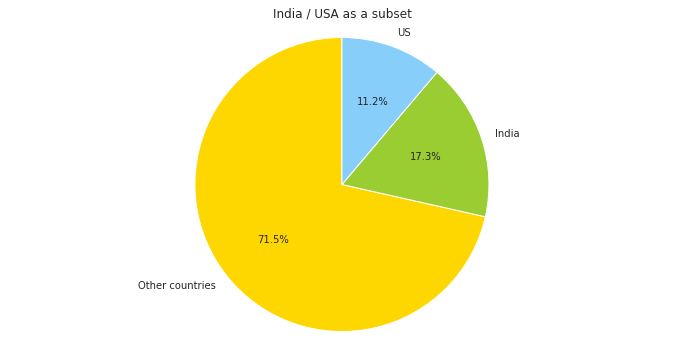

In [82]:
india = df[df["country"] == "India"]
usa = df[df["country"] == "United States of America"]

df_comp = df[(df["country"] == "India") | (df["country"] == "United States of America")].copy()
df_country_comp = df_comp[["country"]]

labels = ["Other countries", "India", "US"]
sizes = [len(df), len(india), len(usa)]
colors = ['gold', 'yellowgreen', 'lightskyblue']

fig1, ax1 = plt.subplots(figsize=figure_size)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
ax1.set_title("India / USA as a subset")
plt.show()

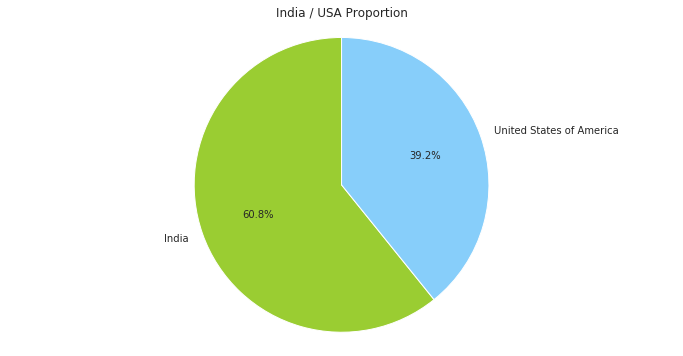

In [93]:
india = df[df["country"] == "India"]
usa = df[df["country"] == "United States of America"]

df_comp = df[(df["country"] == "India") | (df["country"] == "United States of America")].copy()
df_country = df_comp[["country"]]

labels = df_country["country"].value_counts().keys().tolist()
sizes = [len(india), len(usa)]
colors = ['yellowgreen', 'lightskyblue']

fig1, ax1 = plt.subplots(figsize=figure_size)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
ax1.set_title("India / USA Proportion")
plt.show()

### Observations:
* Together India and the US make around 28.5% of all answers to the Kaggle User Survey 2019
* We can see a 60/40 ratio for answers from India versus answers from the US

### Conclusions:
* In order to compare different features of Indian and American Data Scientists we will need to normalize values since the samples are not equal in size

## 1.2 Gender ratio
In tech we still encounter a significant difference in the ratio between men, females and other genders. We were interested in seeing if this ratio would be different between India and the US.

In [52]:
global_gender_dist = perc(df, "gender").rename(columns={"gender" : "global"})
india_gender_dist = perc(india, "gender").rename(columns={"gender" : "india"})
usa_gender_dist = perc(usa, "gender").rename(columns={"gender" : "usa"})

df_gender = global_gender_dist.merge(right=india_gender_dist, how="inner", left_index=True, right_index=True)
df_gender= df_gender.merge(right=usa_gender_dist, how="inner", left_index=True, right_index=True)

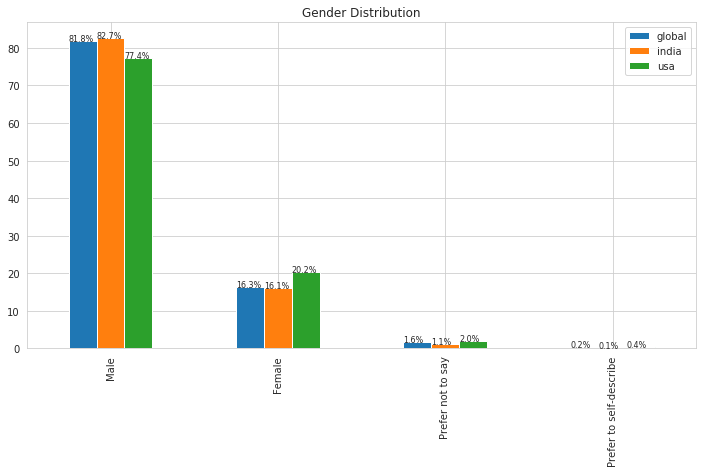

In [53]:
fig, ax = plt.subplots(figsize=figure_size)
df_gender.plot(kind="bar", ax=ax);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=0, fontsize = 8)
    
ax.set_title("Gender Distribution");


### Observations
* While the gender ratio in India is quite similar to the global total ratio the gender ratio in the US shows that there are more answers from people described themselves as women and less from people who described themselves as men in comparison to the global gender ratio


## 1.3 Age distribution
Let's have a look at the age distribution in India, in the US and globally in comparison.

In [54]:
global_age_dist = perc(df, "age").rename(columns={"age" : "global"})
india_age_dist = perc(india, "age").rename(columns={"age" : "india"})
usa_age_dist = perc(usa, "age").rename(columns={"age" : "usa"})

df_age = global_age_dist.merge(right=india_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.merge(right=usa_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.reset_index()
df_age = df_age.rename(columns={"index": "age"}).sort_values(by="age")
df_age = df_age.set_index("age")

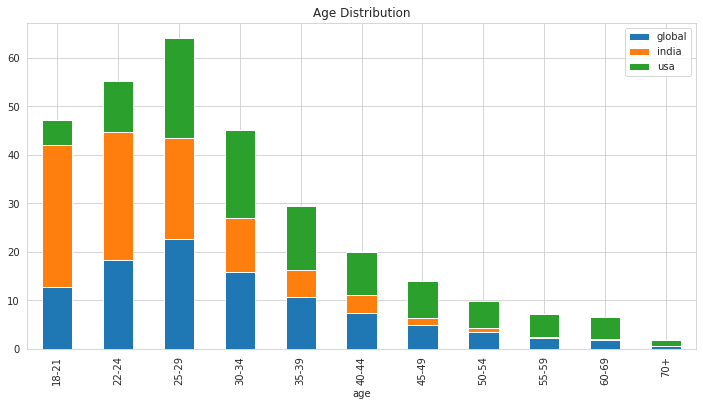

In [55]:
fig, ax = plt.subplots(figsize=figure_size)
df_age.plot(kind="bar", ax=ax, stacked=True);

ax.set_title("Age Distribution");


### Observations:
* Compared to the global age distribution we can see that in India there is a higher percentage of young people between 18 and 29 years of age
* Starting at the 30-34 years bucked there are lower and lower percentages for users from India
* In comparison there are lower percentages for US than globally from young people between 18 and 24 years of age
* Starting at the bucket of 25-29 years there are higher percentages for the US proportionally in comparison to the global age distribution

### Conclusion
* The age distribution shows that the majority of answers from Indian Kaggle users came from younger people under 30 while the majority of answers from US Kaggle users came from people in the middle age between 25 and 39
* This may represent the age distribution of Data Scientists by country, the Kaggle user group by country or both

# 2. Data Science in India and the US

## 2.1 Highest educational degree
Since the age distribution of survey participants from India versus participants from the US showed that Kaggle users from India on average are younger than Kaggle users from the US we had a look at the highest educational degree of the users to see if the age distribution reflects in the distribution of educational degrees.

In [56]:
global_degree_dist = perc(df, "degree").rename(columns={"degree" : "global"})
india_degree_dist = perc(india, "degree").rename(columns={"degree" : "india"})
usa_degree_dist = perc(usa, "degree").rename(columns={"degree" : "usa"})

df_degree = global_degree_dist.merge(right=india_degree_dist, how="inner", left_index=True, right_index=True)
df_degree = df_degree.merge(right=usa_degree_dist, how="inner", left_index=True, right_index=True)

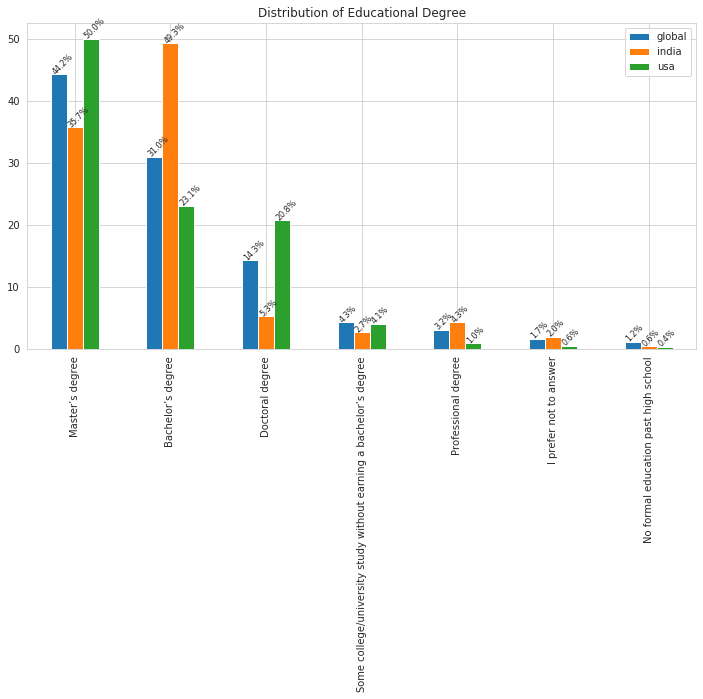

In [94]:
ax = df_degree.plot(kind="bar", figsize=figure_size);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)
    
ax.set_title("Distribution of Educational Degree");


### Observations:
* Percentage wise most people from India who answered to the Kaggle User Survey do have a Bachelor's degree followed by a Master's degree while Doctoral degrees do have lower percentages in the Indian sample
* Answers from people from the US showed that the relative majority of American users does have a Master's degree

### Conclusions:
* Considering the age distribution of Indian and American contributions we assume that Indian participants on average do have slightly lower educational degrees than participants from the US because of their age

## 2.2 Current job position
After looking at the educational degrees let's have a look at the current position of the survey participants and see if our assumption of a relatively high percentage of students in India will be confirmed.

In [58]:
global_position_dist = perc(df, "position").rename(columns={"position" : "global"})
india_position_dist = perc(india, "position").rename(columns={"position" : "india"})
usa_position_dist = perc(usa, "position").rename(columns={"position" : "usa"})

df_position = global_position_dist.merge(right=india_position_dist, how="inner", left_index=True, right_index=True)
df_position = df_position.merge(right=usa_position_dist, how="inner", left_index=True, right_index=True)

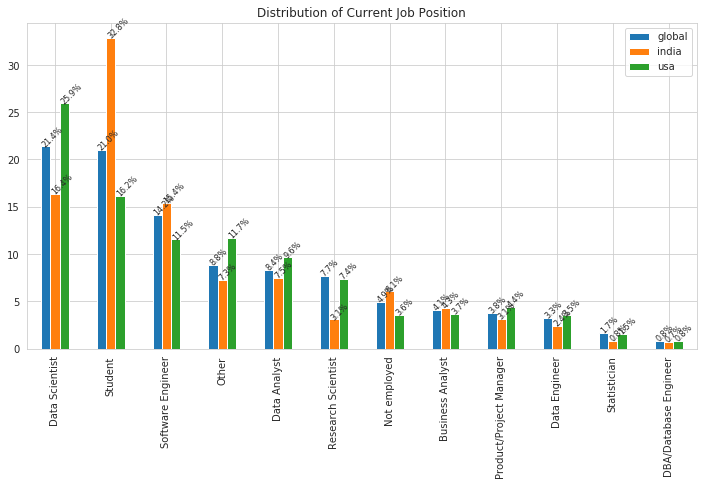

In [95]:
ax = df_position.plot(kind="bar", figsize=figure_size);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)

ax.set_title("Distribution of Current Job Position");


### Observations:
* Within the participants from the US "Data Scientist" is the most commonly chosen job description
* Percentage wise most of the participants from India are currently students

### Conclusions:
* Indeed over one third of the participants from India are currently students. Since this is much more than the percentage of participants from India who stated to be without any educational degree we assume that many  students from India interested in Data Science are currently aming for a second degree, e.g. a Master's degree.
* We assume that these students are going to finish their studies within the next years and become some great Data Scientists, Engineers, Analysts, etc. (or at least some of them is going to be!)

## 2.3 Salary
When looking at the proportion of educational degrees among India and the US we would expect to find a slightly different salary distribution in the US and India. Due to the high amount of students within the Indian participants we expect a higher percentage of people with a low income from India versus a higher percentage of people with a medium or high income in the US according to the high percentage of Master's degrees within the survey answers from the US.

In [60]:
global_salary_dist = perc(df, "salary").rename(columns={"salary" : "global"})
india_salary_dist = perc(india, "salary").rename(columns={"salary" : "india"})
usa_salary_dist = perc(usa, "salary").rename(columns={"salary" : "usa"})

df_salary = global_salary_dist.merge(right=india_salary_dist, how="inner", left_index=True, right_index=True)
df_salary = df_salary.merge(right=usa_salary_dist, how="inner", left_index=True, right_index=True)
df_salary = df_salary.reset_index().rename(columns={"index" : "salary"}).sort_values("salary").set_index("salary")
df_salary = df_salary.reindex(index = ["$0-999", "1,000-1,999", "2,000-2,999",  "3,000-3,999", "4,000-4,999", 
                                       "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999", "20,000-24,999", 
                                       "25,000-29,999", "30,000-39,999", "40,000-49,999", "50,000-59,999", 
                                       "60,000-69,999", "70,000-79,999", "80,000-89,999", "90,000-99,999", 
                                       "100,000-124,999", "125,000-149,999", "150,000-199,999", "200,000-249,999",
                                       "250,000-299,999", "300,000-500,000", "> $500,000"])

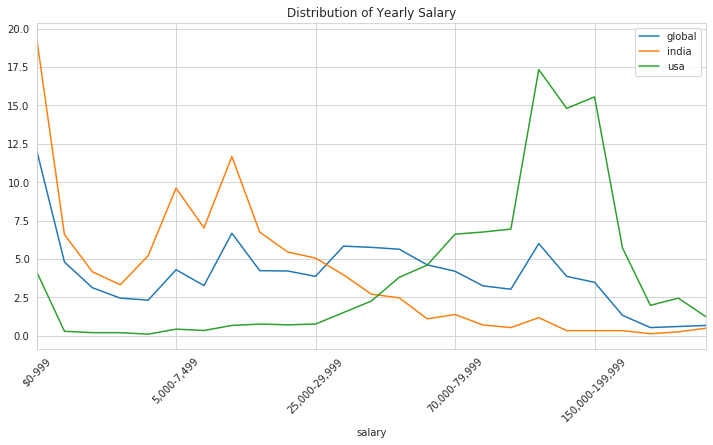

In [96]:
df_salary.plot(kind="line", figsize=figure_size, rot=45).set_title("Distribution of Yearly Salary");


### Observations:
* Within the India sample there is a relatively high percentage of people with an income between 0 and 999 Dollars. Apart from that the most value accumulate around the 5.000 – 10.000 buckets.
* Within the US sample there also is a moderate percentage of people with an income between 0 and 999 Dollars but this percentage is smaller than the percentage within the Indian sample. Apart from that the most values accumulate around the 100.000 and 150.000 Dollar buckets.

### Conclusions:
* We expected to find a relatively lower average income within the Indian sample - both due to the high percentage of students and the economical differences between India and the US. In fact we do find a significantly high amount of people with no or a really low income in India.
* Within the group of survey participants from India the income of people with a regular income seems to accumulate around the 5.000 – 10.000 buckets which may be the mean average salary for Data Scientists in India. The higher the income is the lower the percentage within the Indian sample.
* In the US respectively there is only a relatively small percentage of people with a really low income. The majority groups between 100.000 and 150.000 Dollars which is probably the mean regular salary of Data Scientist of any kind in the US.
* This distribution fits our assumptions regarding the distribution of studying versus working Data Scientists within both samples.

## 2.4 Company size
Looking at the potential of upcoming Data Scientists of any kind within India and the US we want to examine the current state of the DS industry in both our samples. Evaluating the company size offers insights on the exploitment of the potentials of DS across India and the US. 

In [62]:
global_company_size_dist = perc(df, "company_size").rename(columns={"company_size" : "global"})
india_company_size_dist = perc(india, "company_size").rename(columns={"company_size" : "india"})
usa_company_size_dist = perc(usa, "company_size").rename(columns={"company_size" : "usa"})

df_company_size = global_company_size_dist.merge(right=india_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.merge(right=usa_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.reset_index().rename(columns={"index" : "company_size"}).sort_values("company_size").set_index("company_size")
df_company_size = df_company_size.reindex(index = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees", "> 10,000 employees"])


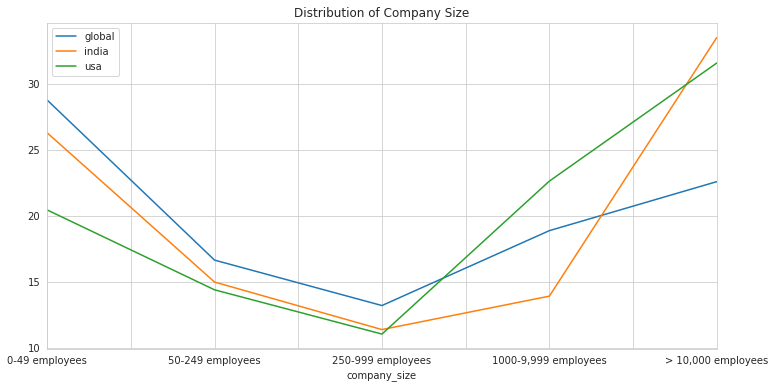

In [97]:
df_company_size.plot(kind="line", figsize=figure_size).set_title("Distribution of Company Size");

### Observations:
* Compared to the US a higher percentage of small Indian companies with 1 – 250 employees applies DS methodology
* Within the company size range between 1.000 and 9.999 employees more companies in the US use DS
* In companies with more than 10.000 employees Indian companies take over again regarding the use of DS tools and methodology. 

### Conclusions:
* Over all company sizes both India and the US do not vary a lot from the global distribution.
* Higher percentages of people from India than from the US work in very small or very big companies applying any kind of Data Science. We can assume that quite small and quite big companies tend to apply Data Science more often than companies of middle size.

# 3. Tools and technologies

## 3.1 Programming languages
We want to know if the tools and technologies used in the Data Science context differ between India and the US. The use of different programming languages could show trends and help young Data Scientists decide which languages to practice first.

In [64]:
languages_india = undummy(india, "Q18")
languages_india = languages_india.drop("2", axis=0)
languages_india = languages_india.rename(index={0: "Python"})
languages_usa = undummy(usa, "Q18")
languages_usa = languages_usa.drop("2", axis=0)
languages_usa = languages_usa.rename(index={0: "Python"})

languages = languages_india.merge(right=languages_usa, how="inner", left_index=True, right_index=True)
languages = languages.rename(columns={"value_x": "india", "value_y": "usa"})

languages_perc = total_to_perc(languages, india, usa, "india", "usa")

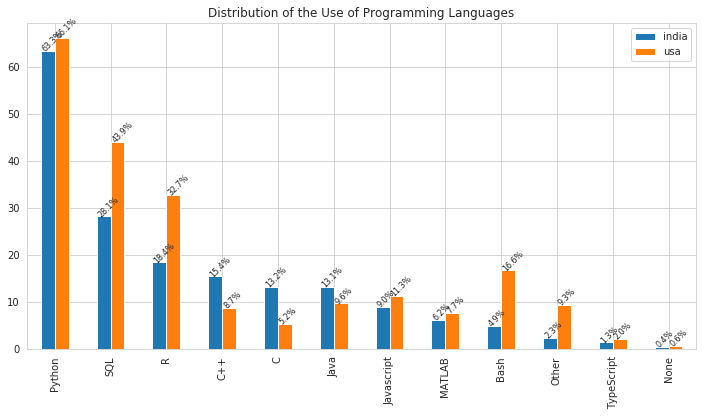

In [98]:
# programming languages percentages
fig, ax = plt.subplots(figsize=figure_size)
languages_perc.plot(kind="bar", ax=ax)

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)

ax.set_title("Distribution of the Use of Programming Languages");
plt.show()


### Observations:
* Within both India and the US Python is the programming language most participants use
* In the US higher percentages of programmers use SQL, R and Bash than in India
* In India higher percentages of programmers use C++, C and Java than in the US

## 3.2 Programming experience
The programming experience in years in conjunction with age and degree can be an indicator for the time the surveys participants have been interested in or practicing Data Science.
Based on the results of the age and educational degree visualization we expect a high percentage of people from India with less programming experience and a more flat distribution for people in the US.

In [66]:
india_exp_dist = perc(india, "Q15").rename(columns={"Q15": "india"})
usa_exp_dist = perc(usa, "Q15").rename(columns={"Q15": "usa"})
df_exp = india_exp_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)
df_exp = df_exp.reindex(["I have never written code", "< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"])

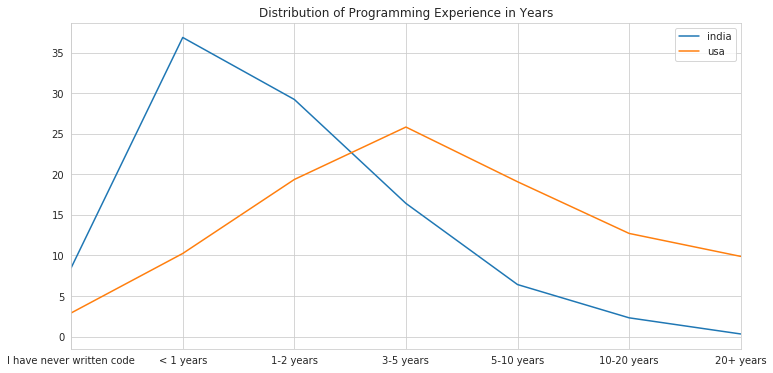

In [100]:
# programming experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp.plot(kind="line", ax=ax)

ax.set_title("Distribution of Programming Experience in Years");
plt.show()

### Observations:
* We see higher percentages for shorter amounts of programming experience in years (< one year until 1 – 2 years) for participants in India. 
* For participants in the US we see a moderate increasing in percentages until the 3 – 5 years mark. After this point the percentages flatten slowly.

### Conclusions:
* As assumed the distribution of programming experience in years is similar to the age distribution for both India and the US

## 3.3 Machine Learning experience
The machine learning experience in years can be an indicator for a digital transformation towards machine learning in the field of Data Science.
Similar to the programming experience in years we assume a high percentage of people from India having a shorter machine learning experience in comparison to people from the US.

In [68]:
india_exp_ml_dist = perc(india, "Q23").rename(columns={"Q23": "india"})
usa_exp_ml_dist = perc(usa, "Q23").rename(columns={"Q23": "usa"})
df_exp_ml = india_exp_ml_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)

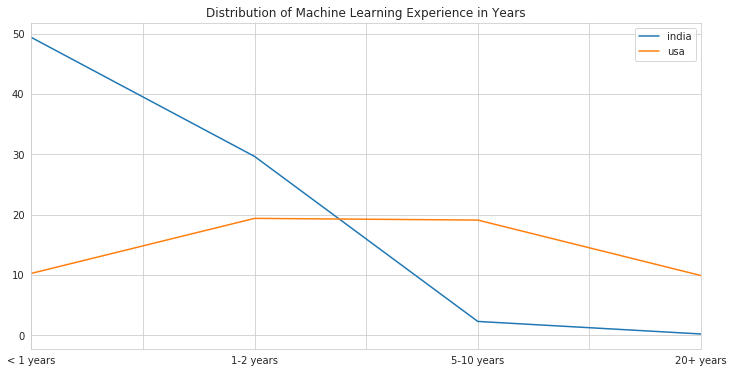

In [101]:
# machine learning experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp_ml.plot(kind="line", ax=ax)

ax.set_title("Distribution of Machine Learning Experience in Years");
plt.show()

### Observations:
* We see a high percentage of Indian participants with machine learning experience between < one year and 1 – 2 years
* In comparison the distribution of machine learning experience of participants from the US is more flat and more equally distributed between < one year and 20+ years

### Conclusions:
* As assumed there is a high percentage of people from India with a lower amount of machine learning experience fitting the age and degree distribution for people from India
* Other than the programming experience almost 50% of participants from India seem to have started learning about machine learning within the last year. This may be an indicator for a growing interest towards machine learning in India and this topic being part of educational programs of Indian students.

## 3.4 Machine learning algorithms
Based on the observations regarding programming and machine learning experience of the survey participants we wanted to know if there are any differences in the distribution of machine learning algorithms between India and the US.

In [70]:
ml_tools_india = undummy(india, "Q24")
ml_tools_india = ml_tools_india.rename(index={0: "Linear or Logistic Regression"})
ml_tools_usa = undummy(usa, "Q24")
ml_tools_usa = ml_tools_usa.rename(index={0: "Linear or Logistic Regression"})

ml_tools = ml_tools_india.merge(right=ml_tools_usa, how="inner", left_index=True, right_index=True)
ml_tools = ml_tools.rename(columns={"value_x": "india", "value_y": "usa"})
ml_tools = ml_tools.drop("1", axis=0)

In [87]:
ml_tools_perc = total_to_perc(ml_tools, india, usa, "india", "usa")

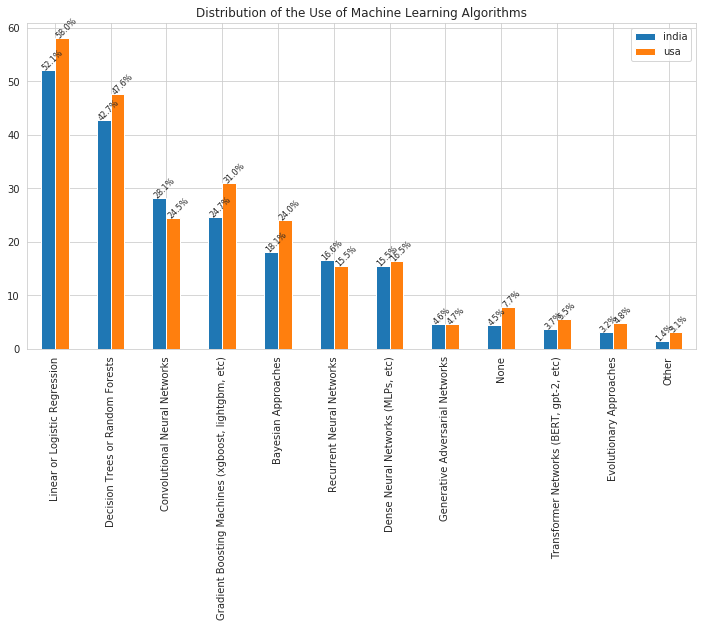

In [102]:
# machine learning tools percentage
fig, ax = plt.subplots(figsize=figure_size)
ml_tools_perc.plot(kind="bar", ax=ax)

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)

ax.set_title("Distribution of the Use of Machine Learning Algorithms");
plt.show()

### Observations:
* We see that for almost all algorithms a slightly higher percentage of participants from the US stated to use these in comparison to participants from India
* The only exception are Convolutional Neural Network algorithms - a slightly higher percentage of participants from India seem to use these

### Conclusions:
* We are not surprised to see lower percentages for most machine learning algorithms in India than in the US since we saw that many participants from India are still in the process of learning about Data Science. 
* Since the machine learning experience of participants from the US is longer on average these participants of course had more time to practice and apply different types of ML algorithms e.g. in their jobs.
* The distribution of the regular application of these machine learning algorithms can also relate to the educational degree and age of the participants: With growing age and education the experience with ML algorithms on a regular basis increases in the field of Data Science.

## 3.5 Learning Resources
Last but not least we wanted to know which resources participants use to learn about Data Science related topics - especially since we saw that a high percentage of participants from India are currently students.

In [72]:
resources_india = undummy(india, "Q13")
resources_usa = undummy(usa, "Q13")

resources = resources_india.merge(right=resources_usa, how="inner", left_index=True, right_index=True)
resources = resources.rename(columns={"value_x": "india", "value_y": "usa"})

resources_perc = total_to_perc(resources, india, usa, "india", "usa")

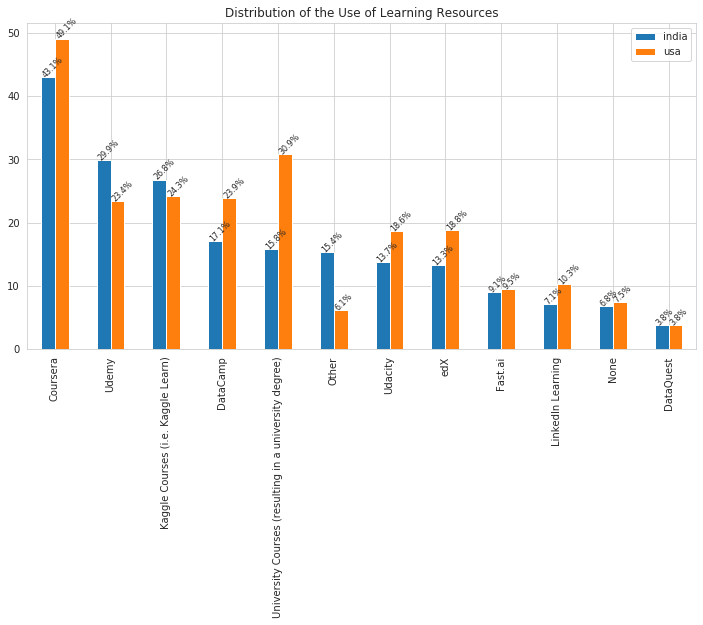

In [103]:
# learning resources percentages
fig, ax = plt.subplots(figsize=figure_size)
resources_perc.plot(kind="bar", ax=ax)

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)

ax.set_title("Distribution of the Use of Learning Resources");
plt.show()

### Observations:
* The most popular learning resource among both participants from India and the US seems to be Coursera
* We see bigger differences in the percentages for participants from India and the US in the use of "Other" learning resorces as well as learning within University Courses

### Conclusions:
* Surprisingly round double the percentage of participants from the US stated to learn through University Courses compared to participants from India. This may mean that even though a higher percentage of Indian participants interested in Data Science is currently studying at university not all of these students study a topic related to Data Science.
* Due to the difference in the student/employed ratio and the ratio of people who learn from University Courses versus people who learn from online resources we assume that a significantly amount of Indian students learn about Data Science online while studying a different topic. This may be an indicator for the assumption that Data Science is of growing importance in different industries in India.